In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.integrate as spi
plt.style.use('seaborn-white')
%matplotlib inline

In [2]:
filename = 'data/dopri5_diff_lambdas.csv'
df = pd.read_csv(filename)
df.head()

,DL,DLS,DS,numerical_thetas,om_lambdas,rs,rs_initial,step,theta
0,196.760858,22.460589,218.116898,0.00001,0.000000,230.315657,230.318417,9.632653e-07,0.00001
1,196.899124,22.493205,218.246033,0.00001,0.020204,230.500248,230.498050,9.632653e-07,0.00001
2,197.037776,22.525826,218.436915,0.00001,0.040408,230.677805,230.678239,9.632653e-07,0.00001
3,197.176816,22.558847,218.612544,0.00001,0.060612,230.858139,230.858988,9.632653e-07,0.00001
4,197.316245,22.591959,218.789249,0.00001,0.080816,231.038904,231.040298,9.632653e-07,0.00001


In [3]:
# # patch
# length_scale = 3.086e22
# H_0 = 7.56e-27 * length_scale
# M = 1474e12 / length_scale

# z_lens1 = np.linspace(0.05, 0.2, 100)
# z_lens2 = []
# for z in z_lens1:
#     z_lens2.extend([z]*50)

# # print(len(z_lens2), len(df.index))
# df['z_lens'] = z_lens2[:len(df.index)]

# def get_distances(z, Omega_Lambda=0):
#     Omega_m = 1 - Omega_Lambda
#     def integrand(z):
#         return 1/np.sqrt(Omega_m*(1+z)**3 + Omega_Lambda)
#     integral, error = spi.quad(integrand, 0, z)
#     comoving = integral/H_0
#     dang = comoving/(1+z)
#     return comoving, dang

# dang_lens = []
# for index, row in df.iterrows():
#     com, dang = get_distances(row.z_lens, row.om_lambdas)
#     dang_lens.append(dang)

# df['DL'] = dang_lens

In [4]:
# df = df[~((df.om_lambdas < 0.707144) & (df.om_lambdas > 0.707142))]

length_scale = 3.086e22
H_0 = 7.56e-27 * length_scale
M = 1474e12 / length_scale

def calc_theta(D_LS, D_L, D_S):
    return np.sqrt(4*M*D_LS/D_L/D_S)

theta_second_order = []
theta_rindler = []
for index, row in df.iterrows():
    Lambda = 3*row.om_lambdas*H_0**2
    coeff = [row.DLS*Lambda*row.DL**3/6/M, row.DS, -4*M*row.DLS/row.DL, 8*M**3*row.DLS/row.DL**3]
    roots = np.roots(coeff)
    roots = roots[roots>0]
    th = np.sqrt(roots)
    rindler = th[np.argmin(row.theta - th)]
    
    coeff2 = [row.DS, -4*M*row.DLS/row.DL, 8*M**3*row.DLS/row.DL**3]
    roots2 = np.roots(coeff2)
    roots2 = roots2[roots2>0]
    th2 = np.sqrt(roots2)
    second_order = th2[np.argmin(row.theta - th2)]
    theta_rindler.append(rindler)
    theta_second_order.append(second_order)

df['theta_second_order'] = theta_second_order
df['theta_rindler'] = theta_rindler


# ## removed percentage!!

df['percentage_diff'] = (df.theta_second_order - df.theta)/df.theta
df['rindler_preds'] = (df.theta_rindler - df.theta)/df.theta

# df['percentage_diff'] = (df.theta_second_order - df.theta)/df.theta*100
# df['percentage_diff'] = (df.rs - df.rs_initial)/df.rs_initial*100

In [5]:
df.head()

,DL,DLS,DS,numerical_thetas,om_lambdas,rs,rs_initial,step,theta,theta_second_order,theta_rindler,percentage_diff,rindler_preds
0,196.760858,22.460589,218.116898,0.00001,0.000000,230.315657,230.318417,9.632653e-07,0.00001,0.00001,0.00001,-0.000052,-0.000052
1,196.899124,22.493205,218.246033,0.00001,0.020204,230.500248,230.498050,9.632653e-07,0.00001,0.00001,0.00001,0.000042,0.000041
2,197.037776,22.525826,218.436915,0.00001,0.040408,230.677805,230.678239,9.632653e-07,0.00001,0.00001,0.00001,-0.000008,-0.000009
3,197.176816,22.558847,218.612544,0.00001,0.060612,230.858139,230.858988,9.632653e-07,0.00001,0.00001,0.00001,-0.000016,-0.000017
4,197.316245,22.591959,218.789249,0.00001,0.080816,231.038904,231.040298,9.632653e-07,0.00001,0.00001,0.00001,-0.000026,-0.000028


In [6]:
stats = df[['om_lambdas', 'percentage_diff', 'rindler_preds']].groupby('om_lambdas').agg(['mean', 'std', 'count'])
stats.columns = [' '.join(col).strip() for col in stats.columns.values]
stats['percentage_diff mean std'] = stats['percentage_diff std']/np.sqrt(stats['percentage_diff count'])
stats['rindler_preds mean std'] = stats['rindler_preds std']/np.sqrt(stats['rindler_preds count'])
stats

,percentage_diff mean,percentage_diff std,percentage_diff count,rindler_preds mean,rindler_preds std,rindler_preds count,percentage_diff mean std,rindler_preds mean std
om_lambdas,,,,,,,,
0.000000,3.083368e-05,0.000059,23,0.000031,0.000059,23,0.000012,0.000012
0.020204,3.646564e-05,0.000068,23,0.000028,0.000066,23,0.000014,0.000014
0.040408,2.794170e-05,0.000059,23,0.000010,0.000051,23,0.000012,0.000011
0.060612,3.617496e-05,0.000055,23,0.000009,0.000049,23,0.000011,0.000010
0.080816,3.241544e-05,0.000066,23,-0.000004,0.000067,23,0.000014,0.000014
0.101020,4.116876e-05,0.000066,23,-0.000004,0.000057,23,0.000014,0.000012
0.121224,3.278350e-05,0.000061,23,-0.000022,0.000053,23,0.000013,0.000011
0.141429,8.378230e-06,0.000052,23,-0.000056,0.000059,23,0.000011,0.000012
0.161633,3.569379e-05,0.000058,23,-0.000039,0.000070,23,0.000012,0.000014


<Container object of 3 artists>

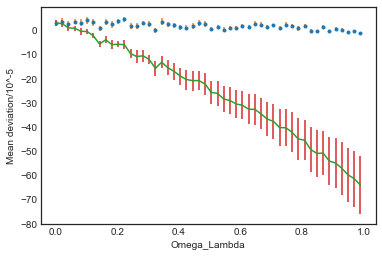

In [7]:
scale = 1e-5
plt.plot(stats.index, stats['percentage_diff mean']/scale, '.')
plt.errorbar(stats.index, stats['percentage_diff mean']/scale, yerr=stats['percentage_diff mean std']/scale, linestyle='none')
plt.xlabel('Omega_Lambda')
plt.ylabel('Mean deviation/10^-5')
plt.plot(stats.index, stats['rindler_preds mean']/scale)
plt.errorbar(stats.index, stats['rindler_preds mean']/scale, yerr=stats['rindler_preds mean std']/scale, linestyle='none')

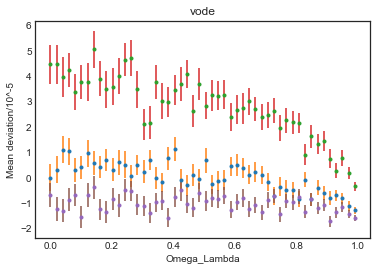

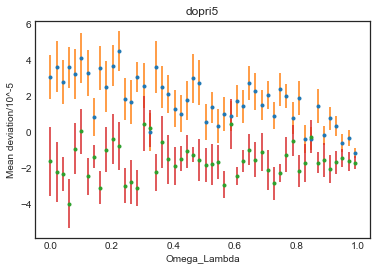

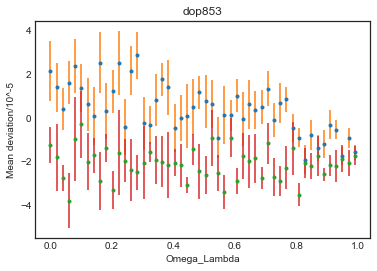

In [9]:
from util import plot_diff_lambdas
plt.figure()
plt.title("vode")
plot_diff_lambdas('data/diff_lambdas_small2.csv', recalculate_distances=True)
plot_diff_lambdas('data/diff_lambdas_step.csv')
plot_diff_lambdas('data/diff_lambdas_step2.csv')
plt.figure()
plt.title("dopri5")
plot_diff_lambdas('data/dopri5_diff_lambdas.csv')
plot_diff_lambdas('data/dopri5_diff_lambdas2.csv')
plt.figure()
plt.title("dop853")
plot_diff_lambdas('data/dop853_diff_lambdas.csv')
plot_diff_lambdas('data/dop853_diff_lambdas2.csv')